# Controls only
Select only Control cells and show UMAP representation

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import config as general_paths
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
HOW_MANY_HIGHLY_VARIABLE_GENES = 16000

In [3]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [4]:
adata_path = os.path.join(input_path,'campari_from_kallisto.h5ad')
adata_all_path = os.path.join(input_path,'campari_raw_all_genes_from_kallisto.h5ad')

# adata_path = os.path.join(input_path,'campari_from_kallisto_excluded_cells_without_some_genes.h5ad')
# adata_all_path = os.path.join(input_path,'campari_raw_all_genes_from_kallisto_excluded_cells_without_some_genes.h5ad')

campari_umap_file = 'control_umap_from_kallisto.h5ad'

matlab_matrix_file_name =  'control_cells_only_from_Kallisto'

NO_PCA = 20 # maybe 20...

In [5]:
adata = ad.read_h5ad(adata_path)
adata_all = ad.read_h5ad(adata_all_path)

In [6]:
adata

AnnData object with n_obs × n_vars = 2126 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [7]:
adata.raw.X

<2126x21764 sparse matrix of type '<class 'numpy.float64'>'
	with 18141481 stored elements in Compressed Sparse Row format>

In [8]:
# Select only the cells where stimulus was 0 (control)
adata_controls = adata[adata.obs['stimulus'] == 0]
adata_all_controls = adata_all[adata_all.obs['stimulus'] == 0]

In [9]:
adata_controls

View of AnnData object with n_obs × n_vars = 606 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [10]:
adata_controls.raw.X

<606x21764 sparse matrix of type '<class 'numpy.float64'>'
	with 4795665 stored elements in Compressed Sparse Row format>

In [11]:
# go back to raw data
adata_controls = adata_controls.raw.to_adata() # (it is already nromalized and log transformed)

In [12]:
# save all normalized and log transformed in raw slot.
adata_controls.raw = adata_controls

In [13]:
adata_controls

AnnData object with n_obs × n_vars = 606 × 21764
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [14]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata_controls, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
adata_controls = adata_controls[:, adata_controls.var.highly_variable] # select and keep only those high variable genes

In [16]:
adata_controls

View of AnnData object with n_obs × n_vars = 606 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [17]:
sc.pp.regress_out(adata_controls, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_controls, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:15)


## Principal Component Analysis

In [18]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_controls, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


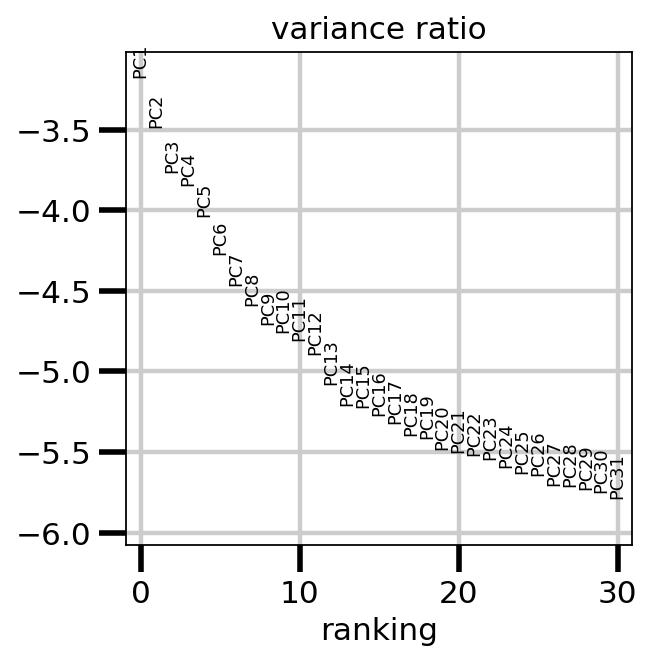

In [19]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function
sc.pl.pca_variance_ratio(adata_controls, log=True)

## Compute the neighborhood graph

In [20]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata_controls, n_neighbors=15, n_pcs=NO_PCA)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph

In [21]:
# We suggest embedding the graph in two dimensions using UMAP 
sc.tl.umap(adata_controls)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


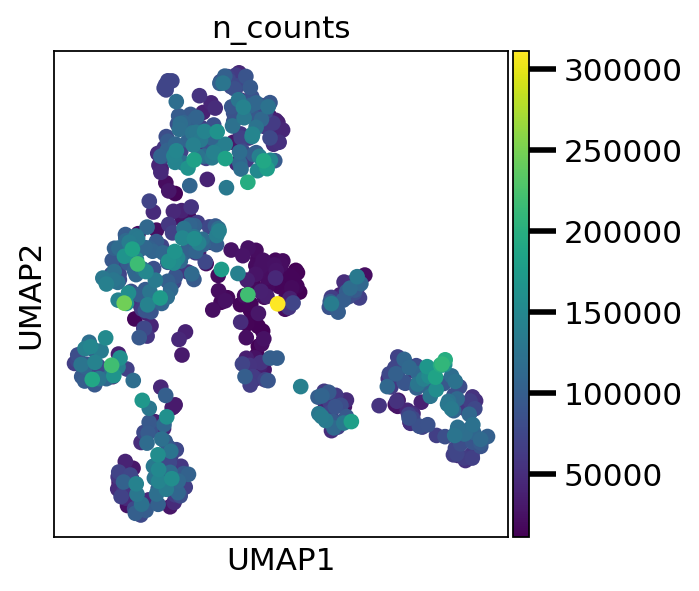

In [22]:
# You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw
sc.pl.umap(adata_controls, color='n_counts', use_raw=False)

## Louvain Clustering

In [23]:
# Perform clustering - using highly variable genes
louvain_paramenters = [0.5,1,1.5,2,2.5]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_controls, resolution=value, key_added=name)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_r2.5', the cluster labels (adata.obs, categorical) (0:00:00)


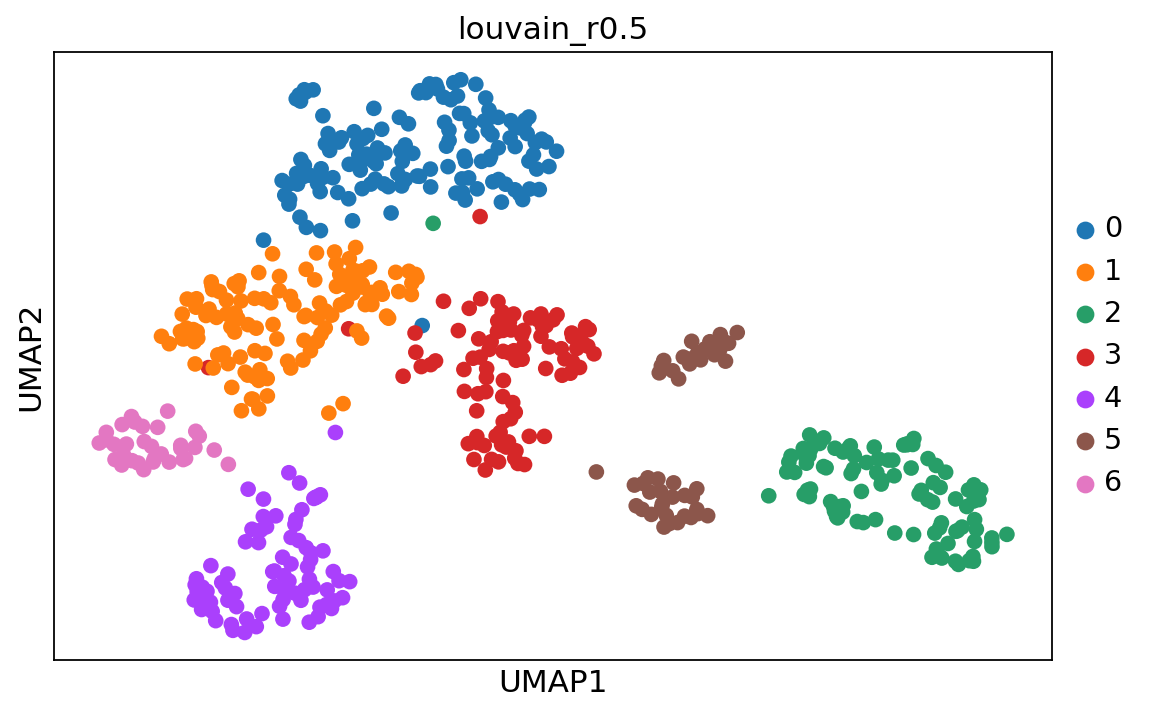

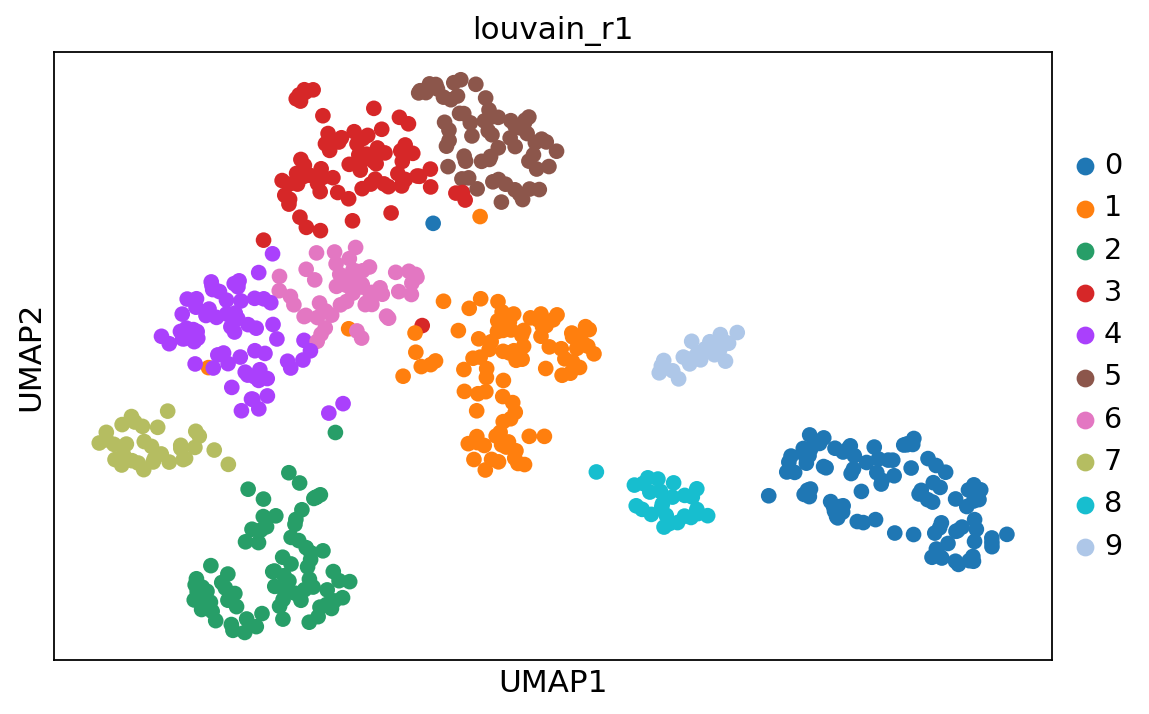

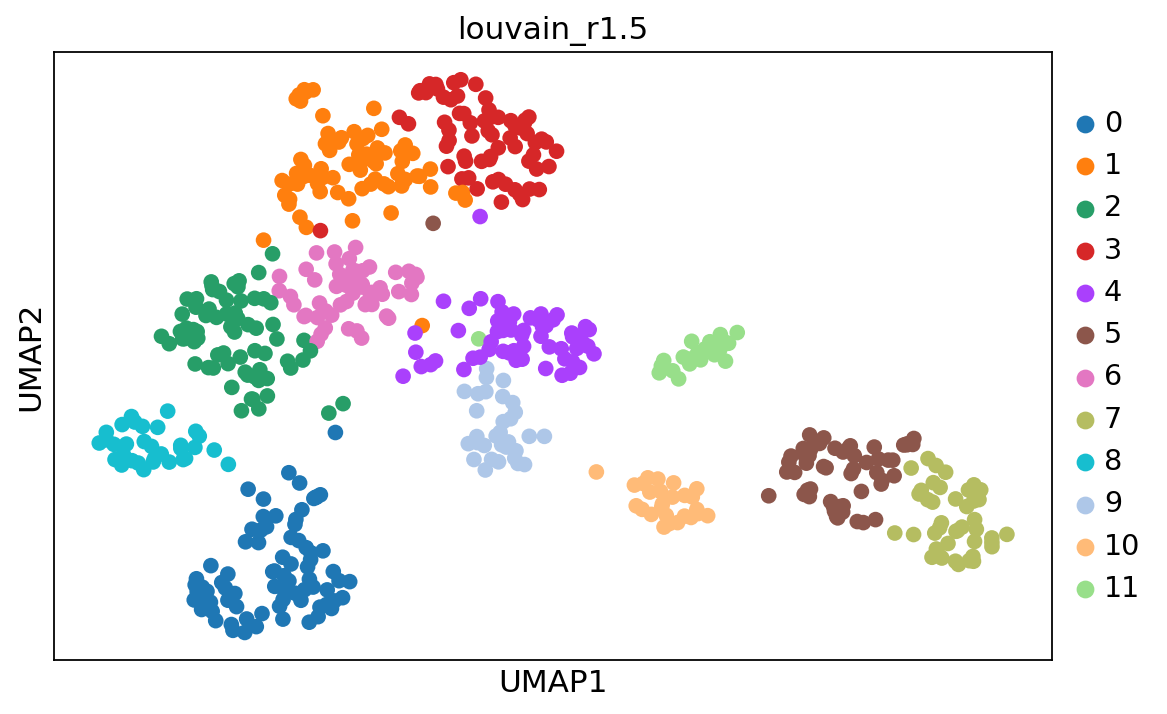

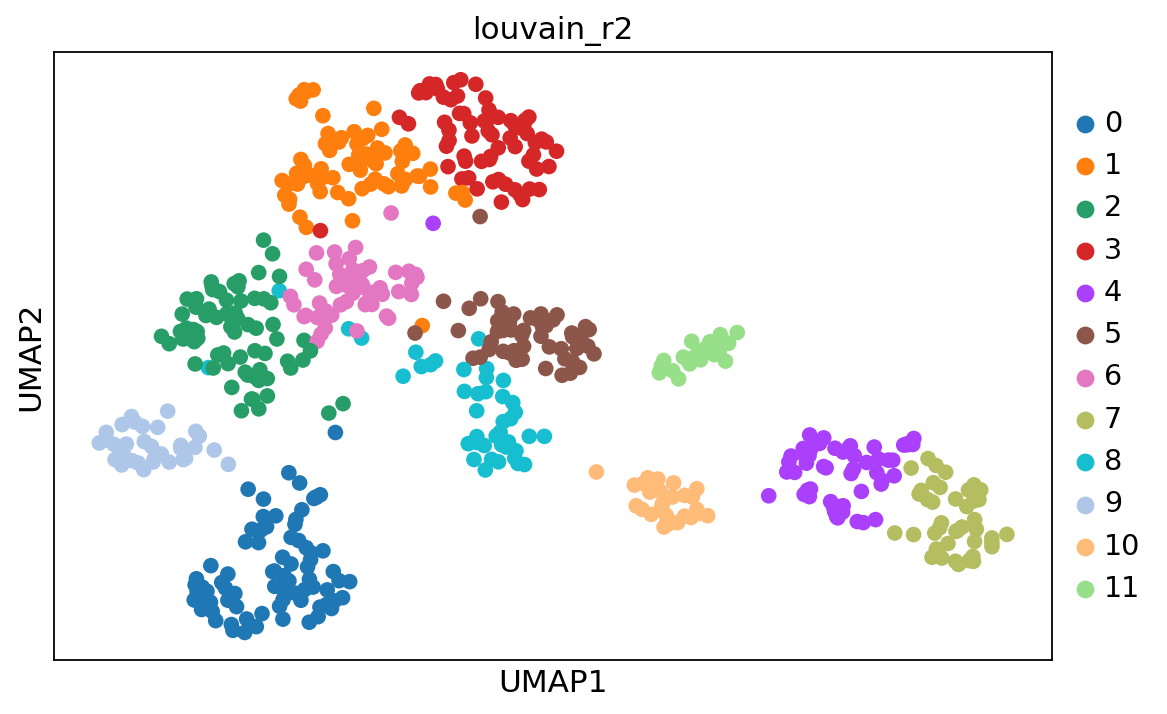

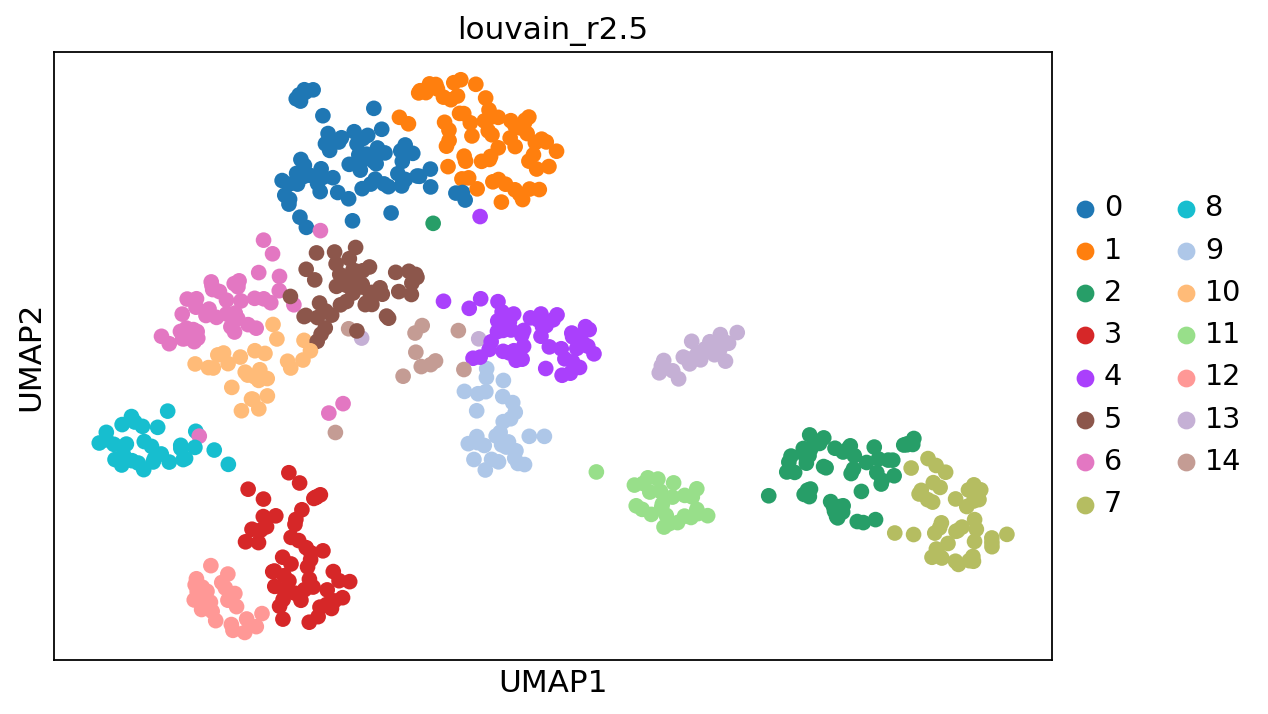

In [24]:
rcParams['figure.figsize']=(8,5)

# Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    # sc.pl.umap(adata_controls, color=[name], use_raw=False, save = '_'+name + '.png')
    sc.pl.umap(adata_controls, color=[name], use_raw=False)

In [25]:
# save only control data with umap 
adata_controls.write_h5ad(
    os.path.join(output_path , campari_umap_file)
)

## Export to Matlab

In [26]:
#################################################################################
#################################################################################
#################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION AS .MAT ################

### we export sparse data matrix, stimuli and flourecence information, umap transformation information and
### louvain transformation

### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata_controls.var['gene_name'])):
    gene_name.append(adata_controls.var['gene_name'].iloc[i])
    
gene_name_all = []
for i in range(len(adata_all_controls.var['gene_name'])):
    gene_name_all.append(adata_all_controls.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x_all = adata_all_controls.X
x = adata_controls.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    stim[i] = adata_controls.obs['stimulus'][i]
    red[i] = adata_controls.obs['red'][i]
    green[i] = adata_controls.obs['green'][i]
    count = 0
    for name in louvain_names:
        louvain[i,count] = adata_controls.obs[name][i]
        count = count + 1
data = {'umap': adata_controls.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names}

from time import strftime
from datetime import datetime
today = datetime.now().strftime("%Y_%m_%d")
scipy.io.savemat(os.path.join(input_path , matlab_matrix_file_name+"_"+str(today)+'.mat'), data)

#################################################################################
#################################################################################
#################################################################################